Stacking uses a meta-learner to combine predictions of base-learners. Predictions of base-learners are used as input for the meta-learner. This increases accuracy, but comes at the trade-off that it is often difficult to analyze the theoretically the reasons behind the classifier's choices.

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import datasets
X_train_tot = pd.read_csv('/Users/alessia/Desktop/churn/X_train.csv')
y_train_tot = pd.read_csv('/Users/alessia/Desktop/churn/y_train.csv')
X_test = pd.read_csv('/Users/alessia/Desktop/churn/X_test.csv')
y_test = pd.read_csv('/Users/alessia/Desktop/churn/y_test.csv')

In [3]:
# split training and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_tot, y_train_tot, test_size=0.2, random_state=42)

In [4]:
# train base models
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y = y_train.values.ravel())

gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y = y_train.values.ravel())

GradientBoostingRegressor(random_state=42)

In [5]:
# make predictions on the validation set
dt_pred = dt.predict(X_val)
rf_pred = rf.predict(X_val)
gb_pred = gb.predict(X_val)

In [6]:
# train meta model
from sklearn.linear_model import LogisticRegression

# combine predictions of base models into a single feature matrix
X_val_meta = np.column_stack((dt_pred, rf_pred, gb_pred))

# train meta-model on the combined feature matrix and the target values
meta_model = LogisticRegression()
meta_model.fit(X_val_meta, y_val)

/Users/alessia/anaconda3/envs/machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [7]:
# make predictions on test set
dt_pred_new = dt.predict(X_test)
rf_pred_new = rf.predict(X_test)
gb_pred_new = gb.predict(X_test)

# save base models
model_name='dt_base.pkl'
model_file=open(model_name,'wb')
pickle.dump(dt, model_file)
model_file.close()

model_name='rf_base.pkl'
model_file=open(model_name,'wb')
pickle.dump(rf, model_file)
model_file.close()

model_name='gb_base.pkl'
model_file=open(model_name,'wb')
pickle.dump(gb, model_file)
model_file.close()

# combine the predictions of the base models into a single feature matrix
X_new_meta = np.column_stack((dt_pred_new, rf_pred_new, gb_pred_new))

# make a prediction using the meta-model
y_new_pred = meta_model.predict(X_new_meta)

accuracy_test_lr = accuracy_score(y_test, y_new_pred)
print(f"Accuracy on test set: {accuracy_test_lr:.4f}")

# AUC on test set
y_probs_test_lr = meta_model.predict_proba(X_new_meta)[:, 1]
fpr_test_lr, tpr_test_lr, _ = roc_curve(y_test, y_probs_test_lr)
roc_auc_test_lr = auc(fpr_test_lr, tpr_test_lr)
print('AUC on test set: {:.4f}'.format(roc_auc_test_lr))

# predict on training set
dt_pred_train = dt.predict(X_train_tot)
rf_pred_train = rf.predict(X_train_tot)
gb_pred_train = gb.predict(X_train_tot)

# combine predictions
X_meta_train = np.column_stack((dt_pred_train, rf_pred_train, gb_pred_train))

# make a prediction using the meta-model
y_train_pred = meta_model.predict(X_meta_train)

accuracy_train_lr = accuracy_score(y_train_tot, y_train_pred)
print(f"Accuracy on training set: {accuracy_train_lr:.4f}")

# AUC on train set
y_probs_train_lr = meta_model.predict_proba(X_meta_train)[:, 1]
fpr_train_lr, tpr_train_lr, _ = roc_curve(y_train_tot, y_probs_train_lr)
roc_auc_train_lr = auc(fpr_train_lr, tpr_train_lr)
print('AUC on training set: {:.4f}'.format(roc_auc_train_lr))

Accuracy on test set: 0.8639
AUC on test set: 0.8872
Accuracy on training set: 0.8857
AUC on training set: 0.9396


In [8]:
# define confusion matrix
import seaborn as sns

classes = ['Non churner', 'Churner']

def plot_confusionmatrix(y_train_pred,y_train):
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Purples', fmt='g')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

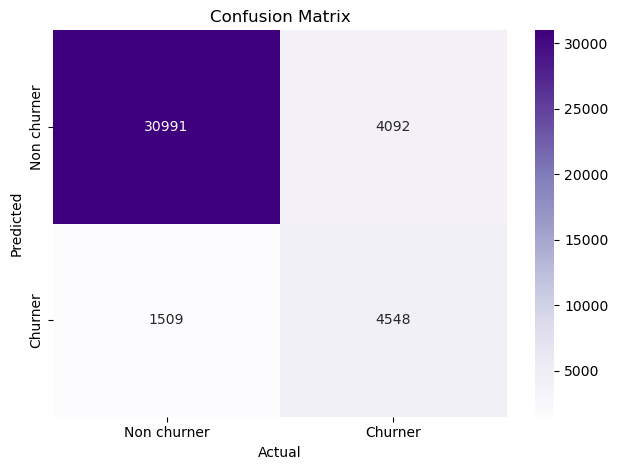

In [9]:
# confusion matrix
plt.title('Confusion matrix')
plot_confusionmatrix(y_new_pred,y_test)

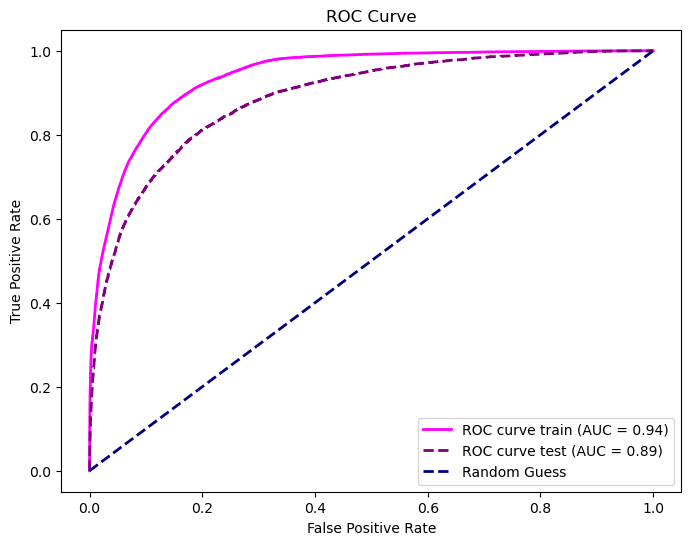

In [10]:
# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train_lr, tpr_train_lr, color = 'magenta', lw= 2, label=f'ROC curve train (AUC = {roc_auc_train_lr:.2f})')
plt.plot(fpr_test_lr, tpr_test_lr, color = 'purple', linestyle='--', lw= 2, label=f'ROC curve test (AUC = {roc_auc_test_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.plot([])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [11]:
# compute other evaluation measures
from sklearn.metrics import precision_score, recall_score, f1_score
# precision (recall)
precision_test_lr = precision_score(y_test, y_new_pred)
# recall
recall_test_lr = recall_score(y_test, y_new_pred)
# f1-measure
f1_test_lr = f1_score(y_test, y_new_pred)

print('Precision on the test set is {}'.format(precision_test_lr))
print('Recall on the test set is {}'.format(recall_test_lr))
print('f1-measure on the test set is {}'.format(f1_test_lr))

Precision on the test set is 0.7508667657256067
Recall on the test set is 0.5263888888888889
f1-measure on the test set is 0.6189018166972852


Stacking yields the best results.

In [12]:
# save model
model_name='stacking.pkl'
model_file=open(model_name,'wb')
pickle.dump(meta_model, model_file)
model_file.close()

# open model
model_file=open(model_name, 'rb')
Model=pickle.load(model_file)